# Computer Vision Coursework: Face Covering Detection

- **Name:** Sajeel Nadeem Alam
- **ID:** 240045404



# Google Colab Setup

Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['test_function.ipynb', 'Code', 'Models', 'Personal_Video', 'CW_Dataset']


Getting data from drive - Lab06

In [3]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2024_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

# Importing Essential Libraries

In [20]:
import os
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd

import cv2
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn import svm, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score
from collections import Counter

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image

import time
import copy

In [5]:
randomState = 42

# Reading Data (Lab 4)

In [6]:
dataset_path = "./CV2024_CW_Dataset"

for root, dirs, files in os.walk(dataset_path):
    print(root, "contains", len(files), "files")

./CV2024_CW_Dataset contains 0 files
./CV2024_CW_Dataset/test contains 0 files
./CV2024_CW_Dataset/test/images contains 458 files
./CV2024_CW_Dataset/test/labels contains 458 files
./CV2024_CW_Dataset/train contains 0 files
./CV2024_CW_Dataset/train/images contains 2394 files
./CV2024_CW_Dataset/train/labels contains 2394 files


In [7]:
def import_selected_data(images_path, labels_path):  # Lab06
    images = []
    labels = []

    filenames = [file for file in sorted(os.listdir(images_path)) if file.endswith('.jpeg')]

    for file in filenames:
        img_path = os.path.join(images_path, file)
        img = io.imread(img_path)
        images.append(img)

        label_filename = os.path.splitext(file)[0] + ".txt"
        label_path = os.path.join(labels_path, label_filename)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label = f.read().strip()
        else:
            label = None

        labels.append(label)

    return images, labels

In [8]:
trainImagesPath = "CV2024_CW_Dataset/train/images"
trainLabelsPath = "CV2024_CW_Dataset/train/labels"
testImagesPath = "CV2024_CW_Dataset/test/images"
testLabelsPath = "CV2024_CW_Dataset/test/labels"

xTrain, yTrain = import_selected_data(trainImagesPath, trainLabelsPath)
xTest, yTest = import_selected_data(testImagesPath, testLabelsPath)

print(f"Loaded {len(xTrain)} training images and {len(yTrain)} labels")
print(f"Loaded {len(xTest)} testing images and {len(yTest)} labels")

print("Training Images classes", Counter(yTrain))
print("Testing Images classes", Counter(yTest))

Loaded 2394 training images and 2394 labels
Loaded 458 testing images and 458 labels
Training Images classes Counter({'1': 1940, '0': 376, '2': 78})
Testing Images classes Counter({'1': 388, '0': 51, '2': 19})


Displaying Sample Image

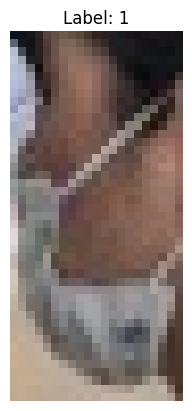

In [9]:
sample_image = xTrain[-1]
sample_label = yTrain[-1]

plt.imshow(sample_image)
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

# Interest point detection and feature descriptor extraction using SIFT (Lab 6)

In [10]:
sift = cv2.SIFT_create()

def getFeatureDescriptors(images, labels):
  descriptorsList = []
  labelsList = []

  for i in range(len(images)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(images[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Append list of descriptors and label to respective lists
    if des is not None:
        descriptorsList.append(des)
        labelsList.append(labels[i])

  return descriptorsList, labelsList

descriptorsList, yTrainLabels = getFeatureDescriptors(xTrain, yTrain)
descriptorsTrainArray = np.vstack(descriptorsList)

# Hyperparameter fine-tuning (SVM)

Setting up hyperparameter space

In [11]:
kValues = [15, 30, 45, 60]
svmCValues = [0.1, 1, 10]
svmGammaValues = [0.01, 0.1, 1]

Grid Search

In [12]:
resultsFolder = "/content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/SVM"

bestSVMScore = float('inf')
bestSVMParams = None
bestSVMClassifier = None
scoring = ['neg_log_loss', 'accuracy', 'recall', 'precision', 'f1', 'roc_auc']

for k in kValues:
    print(f"Training KMeans with k = {k}")

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=randomState).fit(descriptorsTrainArray)

    # Convert descriptors into histograms of codewords for each image
    histogramList = []
    for des in descriptorsList:
        hist = np.zeros(k)
        idx = kmeans.predict(des)  # tells us which codeword (index) each descriptor in the image belongs to in a list
        for j in idx:              # creates normalised histogram of codewords for each image
            hist[j] = hist[j] + (1 / len(des))
        histogramList.append(hist)

    histogramArrayTrain = np.vstack(histogramList)

    svmModel = svm.SVC(kernel='rbf', probability=True, random_state=randomState)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)

    paramGrid = {
        'C': svmCValues,
        'gamma': svmGammaValues
    }

    gridSearch = GridSearchCV(
        svmModel,
        paramGrid,
        cv=cv,
        scoring=scoring,
        refit='neg_log_loss',
        n_jobs=-1,
        verbose=3
    )

    gridSearch.fit(histogramArrayTrain, yTrainLabels)

    resultsDF = pd.DataFrame(gridSearch.cv_results_)
    resultsFile = os.path.join(resultsFolder, f"svmResultsK{k}.csv")
    resultsDF.to_csv(resultsFile, index=False)

    print(f"Results for k={k} saved to {resultsFile}")

    if -(gridSearch.best_score_) < bestSVMScore:
        bestSVMScore = -(gridSearch.best_score_)
        bestSVMParams = {'k': k}
        bestSVMParams.update(gridSearch.best_params_)
        bestSVMClassifier = gridSearch.best_estimator_

print(f"Best Parameters: {bestSVMParams}")
print(f"Best Negative Log Loss: {bestSVMScore:.4f}")

Training KMeans with k = 15
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=15 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/SVM/svmResultsK15.csv
Training KMeans with k = 30
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=30 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/SVM/svmResultsK30.csv
Training KMeans with k = 45
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=45 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/SVM/svmResultsK45.csv
Training KMeans with k = 60
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=60 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/SVM/svmResultsK60.csv
Best Parameters: {'k': 60, 'C': 10, 'gamma': 1}
Best Negative Log Loss: 0.4847


# Evaluating best model on test set (SVM)

In [13]:
bestSVMK = bestSVMParams['k']
kmeansBestSVM = KMeans(n_clusters=bestSVMK, n_init='auto', random_state=randomState).fit(descriptorsTrainArray)

Creating normalised histogram of codewords for testing set

In [14]:
histogramTestList = []

for i in range(len(xTest)):
    img = img_as_ubyte(color.rgb2gray(xTest[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)
        idx = kmeansBestSVM.predict(des)
        for j in idx:
            hist[j] = hist[j] + (1 / len(des))
        # hist = scale.transform(hist.reshape(1, -1))
        histogramTestList.append(hist)
    else:
        histogramTestList.append(None)

# Remove potential cases of images with no descriptors
idxNotEmpty = [i for i, x in enumerate(histogramTestList) if x is not None]
histogramTestList = [histogramTestList[i] for i in idxNotEmpty]
yTestUpdated = [yTest[i] for i in idxNotEmpty]
histogramTestArray = np.vstack(histogramTestList)

In [15]:
yPred = bestSVMClassifier.predict(histogramTestArray).tolist()

In [16]:
print(f"""Classification report for classifier {bestSVMClassifier}:
      {classification_report(yTestUpdated, yPred, zero_division=0)}\n""")

precision, recall, f1, _ = precision_recall_fscore_support(yTestUpdated, yPred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Classification report for classifier SVC(C=10, gamma=1, probability=True, random_state=42):
                    precision    recall  f1-score   support

           0       0.43      0.18      0.25        50
           1       0.87      0.97      0.92       384
           2       0.00      0.00      0.00        19

    accuracy                           0.85       453
   macro avg       0.43      0.38      0.39       453
weighted avg       0.78      0.85      0.81       453


Precision: 0.7811766354812713
Recall: 0.8454746136865342
F1 Score: 0.8050244069272144


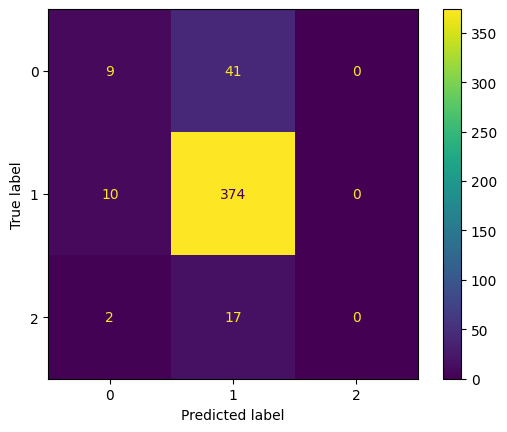

In [17]:
classLabels = ['0', '1', '2']
cm = confusion_matrix(yTestUpdated, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classLabels)
disp.plot()
plt.show()

# Hyperparameter fine-tuning (MLP)

Setting up hyperparameter space

In [18]:
kValues = [15, 30, 45, 60]

hidden_layer_sizes = [(50,), (100,), (100, 50)]
learning_rate_init = [0.001, 0.01, 0.1]

Grid Search

In [19]:
resultsFolder = "/content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/MLP"

bestMLPScore = float('inf')
bestMLPParams = None
bestMLPClassifier = None
scoring = ['neg_log_loss', 'accuracy', 'recall', 'precision', 'f1', 'roc_auc']

for k in kValues:
    print(f"Training KMeans with k = {k} ...")

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=randomState).fit(descriptorsTrainArray)

    # Convert descriptors into histograms of codewords for each image
    histogramList = []
    for des in descriptorsList:
        hist = np.zeros(k)
        idx = kmeans.predict(des)  # tells us which codeword (index) each descriptor in the image belongs to in a list
        for j in idx:              # creates normalised histogram of codewords for each image
            hist[j] = hist[j] + (1 / len(des))
        histogramList.append(hist)

    histogramArrayTrain = np.vstack(histogramList)

    mlpModel = MLPClassifier(max_iter=1000, solver='sgd', activation='relu', random_state=randomState)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)

    paramGrid = {
      'hidden_layer_sizes': hidden_layer_sizes,
      'learning_rate_init': learning_rate_init
    }

    gridSearch = GridSearchCV(
        mlpModel,
        paramGrid,
        cv=cv,
        scoring=scoring,
        refit='neg_log_loss',
        n_jobs=-1,
        verbose=3
    )

    gridSearch.fit(histogramArrayTrain, yTrainLabels)

    resultsDF = pd.DataFrame(gridSearch.cv_results_)
    resultsFile = os.path.join(resultsFolder, f"mlpResultsK{k}.csv")
    resultsDF.to_csv(resultsFile, index=False)

    if -(gridSearch.best_score_) < bestMLPScore:
        bestMLPScore = -(gridSearch.best_score_)
        bestMLPParams = {'k': k}
        bestMLPParams.update(gridSearch.best_params_)
        bestMLPClassifier = gridSearch.best_estimator_

print(f"Best Parameters: {bestMLPParams}")
print(f"Best Negative Log Loss: {bestMLPScore:.4f}")

Training KMeans with k = 15 ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Training KMeans with k = 30 ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Training KMeans with k = 45 ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Training KMeans with k = 60 ...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'k': 60, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
Best Negative Log Loss: 0.4884


# Evaluating best model on test set (MLP)

In [20]:
bestMLPK = bestMLPParams['k']
kmeansBestMLP = KMeans(n_clusters=bestMLPK, n_init='auto', random_state=42).fit(descriptorsTrainArray)

Creating normalised histogram of codewords for testing set

In [21]:
histogramTestList = []

for i in range(len(xTest)):
    img = img_as_ubyte(color.rgb2gray(xTest[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)
        idx = kmeansBestMLP.predict(des)
        for j in idx:
            hist[j] = hist[j] + (1 / len(des))
        # hist = scale.transform(hist.reshape(1, -1))
        histogramTestList.append(hist)
    else:
        histogramTestList.append(None)

# Remove potential cases of images with no descriptors
idxNotEmpty = [i for i, x in enumerate(histogramTestList) if x is not None]
histogramTestList = [histogramTestList[i] for i in idxNotEmpty]
yTestUpdated = [yTest[i] for i in idxNotEmpty]
histogramTestArray = np.vstack(histogramTestList)

In [22]:
yPred = bestMLPClassifier.predict(histogramTestArray).tolist()

In [23]:
print(f"""Classification report for classifier {bestMLPClassifier}:
      {classification_report(yTestUpdated, yPred, zero_division=0)}\n""")

precision, recall, f1, _ = precision_recall_fscore_support(yTestUpdated, yPred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Classification report for classifier MLPClassifier(learning_rate_init=0.01, max_iter=1000, random_state=42,
              solver='sgd'):
                    precision    recall  f1-score   support

           0       0.45      0.28      0.35        50
           1       0.87      0.96      0.92       384
           2       0.00      0.00      0.00        19

    accuracy                           0.85       453
   macro avg       0.44      0.41      0.42       453
weighted avg       0.79      0.85      0.81       453


Precision: 0.7910665717651909
Recall: 0.8454746136865342
F1 Score: 0.8143199299884719


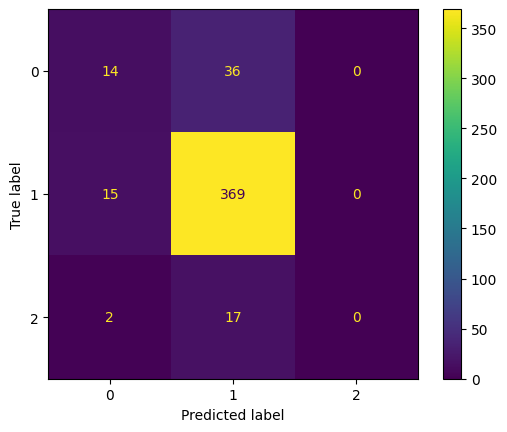

In [24]:
classLabels = ['0', '1', '2']
cm = confusion_matrix(yTestUpdated, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classLabels)
disp.plot()
plt.show()

#Implementing CNN (Lab 8)

In [10]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


Preparing data

In [11]:
def computeMeanStd(images):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    totalSamples = 0

    for img in images:
        img_tensor = torch.tensor(img, dtype=torch.float32) / 255.0
        img_tensor = img_tensor.permute(2, 0, 1)
        mean += img_tensor.mean(dim=[1, 2])
        std += img_tensor.std(dim=[1, 2])
        totalSamples += 1

    mean /= totalSamples
    std /= totalSamples
    return mean, std


dataMeans, dataStds = computeMeanStd(xTrain)
print("Computed Mean (R, G, B):", dataMeans)
print("Computed Std (R, G, B):", dataStds)

Computed Mean (R, G, B): tensor([0.5015, 0.4593, 0.4397])
Computed Std (R, G, B): tensor([0.2026, 0.2074, 0.2152])


In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(dataMeans.tolist(), dataStds.tolist())
])

In [13]:
xTrainTensor = torch.stack([transform(Image.fromarray(img)) for img in xTrain])
xTestTensor = torch.stack([transform(Image.fromarray(img)) for img in xTest])

In [14]:
yTrainNumerical = [int(label) for label in yTrain]
yTestNumerical = [int(label) for label in yTest]

yTrainTensor = torch.tensor(yTrainNumerical)
yTestTensor = torch.tensor(yTestNumerical)

In [15]:
trainDataset = TensorDataset(xTrainTensor, yTrainTensor)
testDataset = TensorDataset(xTestTensor, yTestTensor)

trainLoader = DataLoader(trainDataset, batch_size=4, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=4, shuffle=False)

Defining training function

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('----------------')

        model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in trainLoader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(trainDataset)
        epoch_acc = running_corrects.double() / len(trainDataset)

        print(f"Train loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")


        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best training acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model

In [19]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.6MB/s]


In [21]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

In [22]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------------
Train loss: 0.3109 acc: 0.9014
Epoch 2/25
----------------
Train loss: 0.1464 acc: 0.9524
Epoch 3/25
----------------
Train loss: 0.1142 acc: 0.9657
Epoch 4/25
----------------
Train loss: 0.0898 acc: 0.9762
Epoch 5/25
----------------
Train loss: 0.0842 acc: 0.9820
Epoch 6/25
----------------
Train loss: 0.0645 acc: 0.9850
Epoch 7/25
----------------
Train loss: 0.0557 acc: 0.9866
Epoch 8/25
----------------
Train loss: 0.0173 acc: 0.9958
Epoch 9/25
----------------
Train loss: 0.0093 acc: 0.9992
Epoch 10/25
----------------
Train loss: 0.0321 acc: 0.9933
Epoch 11/25
----------------
Train loss: 0.0100 acc: 0.9983
Epoch 12/25
----------------
Train loss: 0.0198 acc: 0.9967
Epoch 13/25
----------------
Train loss: 0.0064 acc: 0.9996
Epoch 14/25
----------------
Train loss: 0.0160 acc: 0.9975
Epoch 15/25
----------------
Train loss: 0.0121 acc: 0.9979
Epoch 16/25
----------------
Train loss: 0.0207 acc: 0.9975
Epoch 17/25
----------------
Train loss: 0.0105 a

Saving best model

In [24]:
torch.save(model_ft.state_dict(), 'cnnModel.pth')

# Evaluating best model on test set (CNN)

In [25]:
def testModel(model, testLoader, criterion, device):
    model.eval()
    corrects = 0
    total = 0
    runningLoss = 0.0

    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            runningLoss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)


    accuracy = corrects.double() / total
    avg_loss = runningLoss / total

    return accuracy, avg_loss

In [26]:
accuracy, avgLoss = testModel(model_ft, testLoader, criterion, device)

# Print the results
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Loss: {avgLoss:.4f}')

Test Accuracy: 0.9738
Test Loss: 0.0890
